In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from pathlib import Path
from sklearn.decomposition import PCA
from mbeml.featurization import get_ligand_features
from mbeml.constants import LigandFeatures

In [2]:
plt.style.use("mbeml.mbeml")

In [3]:
data_dir = Path("../../data")

df_train = pd.read_csv(data_dir / "training_data.csv")
df_val = pd.read_csv(data_dir / "validation_data.csv")
df_comp = pd.read_csv(data_dir / "composition_test_data.csv")
df_lig = pd.read_csv(data_dir / "ligand_test_data.csv")

In [4]:
# Prepare standard-RACs
standard_racs_train = get_ligand_features(df_train, LigandFeatures.STANDARD_RACS)
standard_racs_val = get_ligand_features(df_val, LigandFeatures.STANDARD_RACS)
standard_racs_comp = get_ligand_features(df_comp, LigandFeatures.STANDARD_RACS)
standard_racs_lig = get_ligand_features(df_lig, LigandFeatures.STANDARD_RACS)
# Normalize
norm_standard_racs = np.max(np.abs(standard_racs_train), axis=0)
norm_standard_racs[norm_standard_racs < 1e-6] = 1.0

standard_racs_train /= norm_standard_racs
standard_racs_val /= norm_standard_racs
standard_racs_comp /= norm_standard_racs
standard_racs_lig /= norm_standard_racs

In [5]:
# Prepare ligand-RACs
ligand_racs_train = get_ligand_features(df_train, LigandFeatures.LIGAND_RACS).reshape(
    len(df_train) * 6, -1
)
ligand_racs_val = get_ligand_features(df_val, LigandFeatures.LIGAND_RACS).reshape(
    len(df_val) * 6, -1
)
ligand_racs_comp = get_ligand_features(df_comp, LigandFeatures.LIGAND_RACS).reshape(
    len(df_comp) * 6, -1
)
ligand_racs_lig = get_ligand_features(df_lig, LigandFeatures.LIGAND_RACS).reshape(
    len(df_lig) * 6, -1
)
# Normalize
norm_ligand_racs = np.max(np.abs(ligand_racs_train), axis=0)
norm_ligand_racs[norm_ligand_racs < 1e-6] = 1.0

ligand_racs_train /= norm_ligand_racs
ligand_racs_val /= norm_ligand_racs
ligand_racs_comp /= norm_ligand_racs
ligand_racs_lig /= norm_ligand_racs

In [6]:
def unique_racs(racs):
    res = []
    for v in racs:
        for w in res:
            if np.linalg.norm(w - v) < 1e-6:
                break
        else:
            res.append(v)
    return np.array(res)

In [7]:
# Check that featurization is unique, training and val should have 107 unique ligands
assert len(unique_racs(np.concatenate([ligand_racs_train, ligand_racs_val]))) == 107
# Ligand test set should have 21 unique ligands
assert len(unique_racs(ligand_racs_lig)) == 21
# Check that there are not "collisions" between the 107 training/validation ligands and the 21 test ligands
assert (
    len(
        unique_racs(
            np.concatenate([ligand_racs_train, ligand_racs_val, ligand_racs_lig])
        )
    )
    == 107 + 21
)

In [8]:
# Find uniques
unique_standard_racs_train = unique_racs(standard_racs_train)
unique_standard_racs_val = unique_racs(standard_racs_val)
unique_standard_racs_comp = unique_racs(standard_racs_comp)
unique_standard_racs_lig = unique_racs(standard_racs_lig)
# Same for ligand-RACs
unique_ligand_racs_train = unique_racs(ligand_racs_train)
unique_ligand_racs_val = unique_racs(ligand_racs_val)
unique_ligand_racs_comp = unique_racs(ligand_racs_comp)
unique_ligand_racs_lig = unique_racs(ligand_racs_lig)

# 2D PCA

In [9]:
pca2d_standard = PCA(n_components=2)
pc_standard_racs_train = pca2d_standard.fit_transform(unique_standard_racs_train)
pc_standard_racs_val = pca2d_standard.transform(unique_standard_racs_val)
pc_standard_racs_comp = pca2d_standard.transform(unique_standard_racs_comp)
pc_standard_racs_lig = pca2d_standard.transform(unique_standard_racs_lig)

pca2d_ligand = PCA(n_components=2)
pc_ligand_racs_train = pca2d_ligand.fit_transform(unique_ligand_racs_train)
pc_ligand_racs_val = pca2d_ligand.transform(unique_ligand_racs_val)
pc_ligand_racs_comp = pca2d_ligand.transform(unique_ligand_racs_comp)
pc_ligand_racs_lig = pca2d_ligand.transform(unique_ligand_racs_lig)

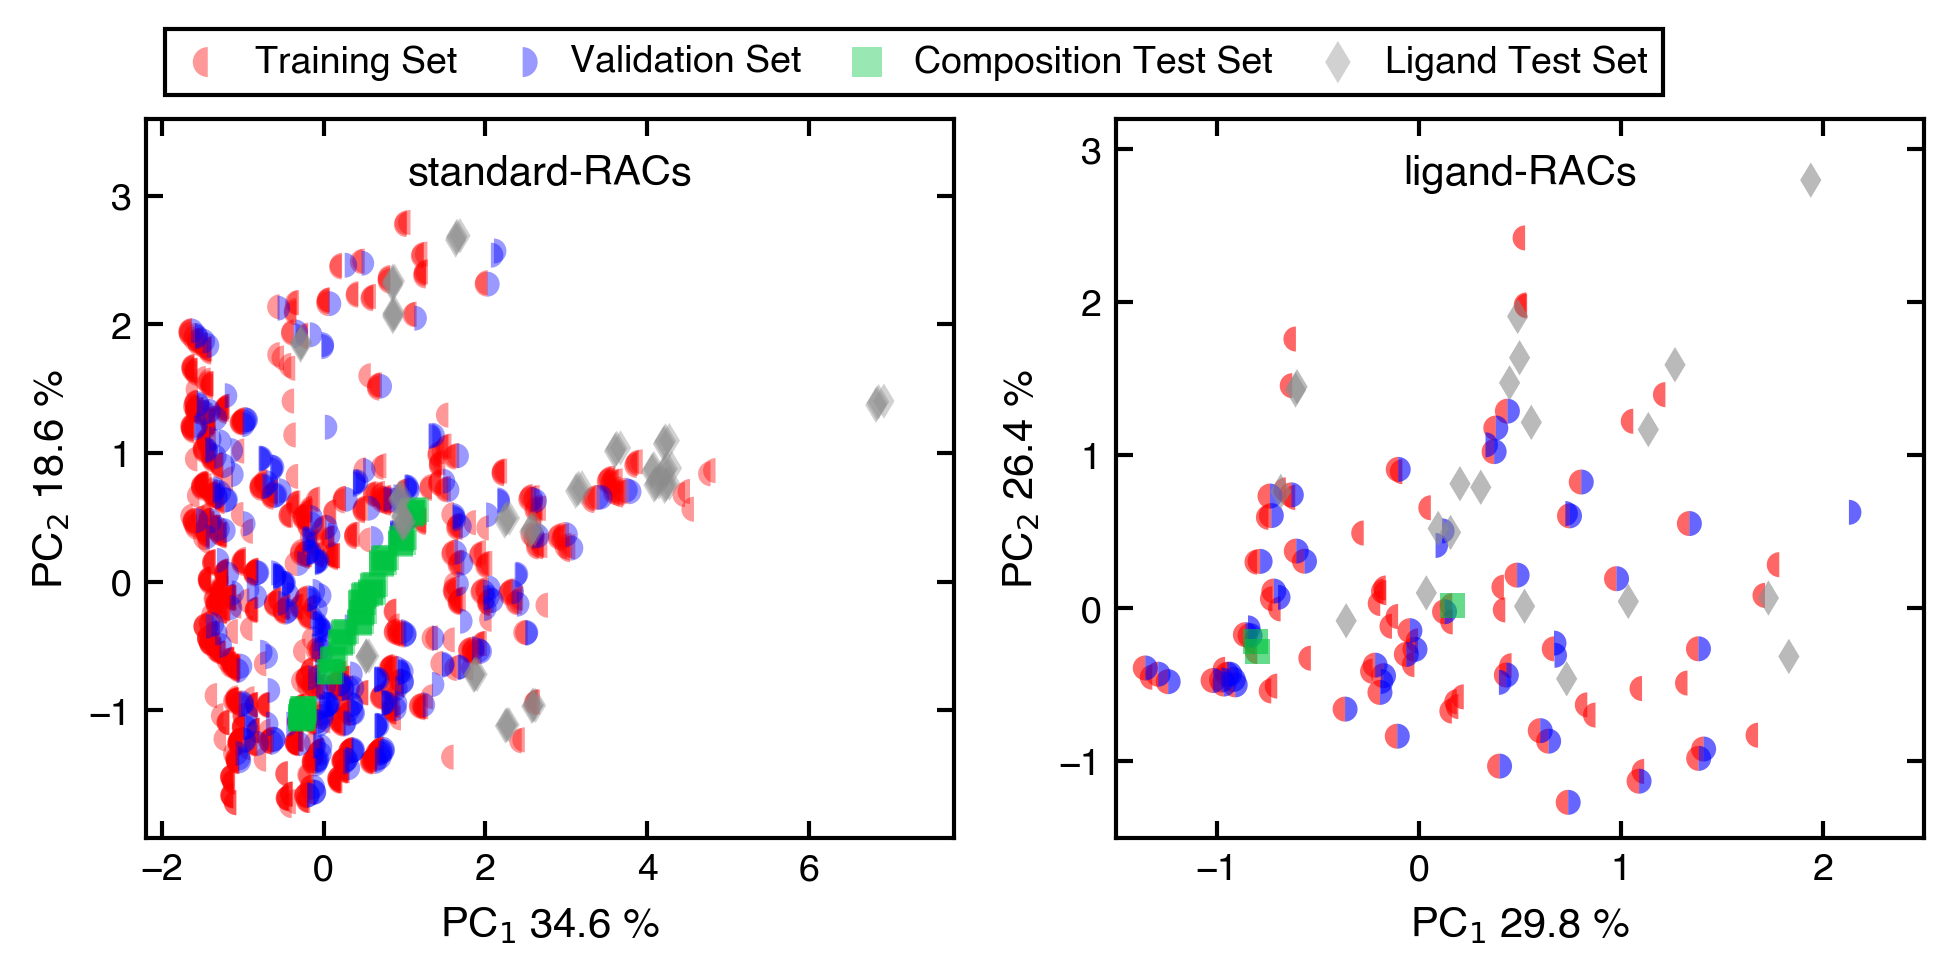

In [15]:
fig, ax = plt.subplots(
    figsize=(6.66, 0.5 * 6.66),
    dpi=300,
    ncols=2,
    gridspec_kw={
        "wspace": 0.2,
        "left": 0.08,
        "right": 0.97,
        "bottom": 0.15,
        "top": 0.87,
    },
)

scatter_kwargs = {"alpha": 0.4, "ec": "None"}

ax[0].scatter(
    pc_standard_racs_train[:, 0],
    pc_standard_racs_train[:, 1],
    marker=MarkerStyle("o", fillstyle="left"),
    label="Training Set",
    **scatter_kwargs,
)
ax[0].scatter(
    pc_standard_racs_val[:, 0],
    pc_standard_racs_val[:, 1],
    marker=MarkerStyle("o", fillstyle="right"),
    label="Validation Set",
    **scatter_kwargs,
)
ax[0].scatter(
    pc_standard_racs_comp[:, 0],
    pc_standard_racs_comp[:, 1],
    marker=MarkerStyle("s"),
    label="Composition Test Set",
    **scatter_kwargs,
)
ax[0].scatter(
    pc_standard_racs_lig[:, 0],
    pc_standard_racs_lig[:, 1],
    marker=MarkerStyle("d"),
    label="Ligand Test Set",
    **scatter_kwargs,
)
ax[0].text(0.5, 0.95, "standard-RACs", transform=ax[0].transAxes, ha="center", va="top")
ax[0].set_xlabel(f"PC$_1$ {pca2d_standard.explained_variance_ratio_[0]*100:.1f} %")
ax[0].set_ylabel(f"PC$_2$ {pca2d_standard.explained_variance_ratio_[1]*100:.1f} %")
ax[0].set_xlim(-2.2, 7.8)
ax[0].set_ylim(-1.99, 3.6)

ax[0].legend(ncols=4, loc="upper left", bbox_to_anchor=(0.0, 1.15))

# Slightly higher alpha because we expect less overlap
scatter_kwargs = {"alpha": 0.6, "ec": "None"}

ax[1].scatter(
    pc_ligand_racs_train[:, 0],
    pc_ligand_racs_train[:, 1],
    marker=MarkerStyle("o", fillstyle="left"),
    **scatter_kwargs,
)
ax[1].scatter(
    pc_ligand_racs_val[:, 0],
    pc_ligand_racs_val[:, 1],
    marker=MarkerStyle("o", fillstyle="right"),
    **scatter_kwargs,
)
ax[1].scatter(
    pc_ligand_racs_comp[:, 0],
    pc_ligand_racs_comp[:, 1],
    marker=MarkerStyle("s"),
    **scatter_kwargs,
)
ax[1].scatter(
    pc_ligand_racs_lig[:, 0],
    pc_ligand_racs_lig[:, 1],
    marker=MarkerStyle("d"),
    **scatter_kwargs,
)
ax[1].text(0.5, 0.95, "ligand-RACs", transform=ax[1].transAxes, ha="center", va="top")
ax[1].set_xlabel(f"PC$_1$ {pca2d_ligand.explained_variance_ratio_[0]*100:.1f} %")
ax[1].set_ylabel(f"PC$_2$ {pca2d_ligand.explained_variance_ratio_[1]*100:.1f} %")
ax[1].set_xlim(-1.5, 2.5)
ax[1].set_ylim(-1.5, 3.2)

fig.savefig("plots/pca_feature_spaces.pdf")